ArithmeticErrorDiscretize continous variable into coarse classes (similar to Schopp et al)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import re

import matplotlib.pyplot as plt

In [3]:
df_candidates = pd.read_excel("../input_survey_data/input_data_business.xlsx")



#### Plot distirbutions again

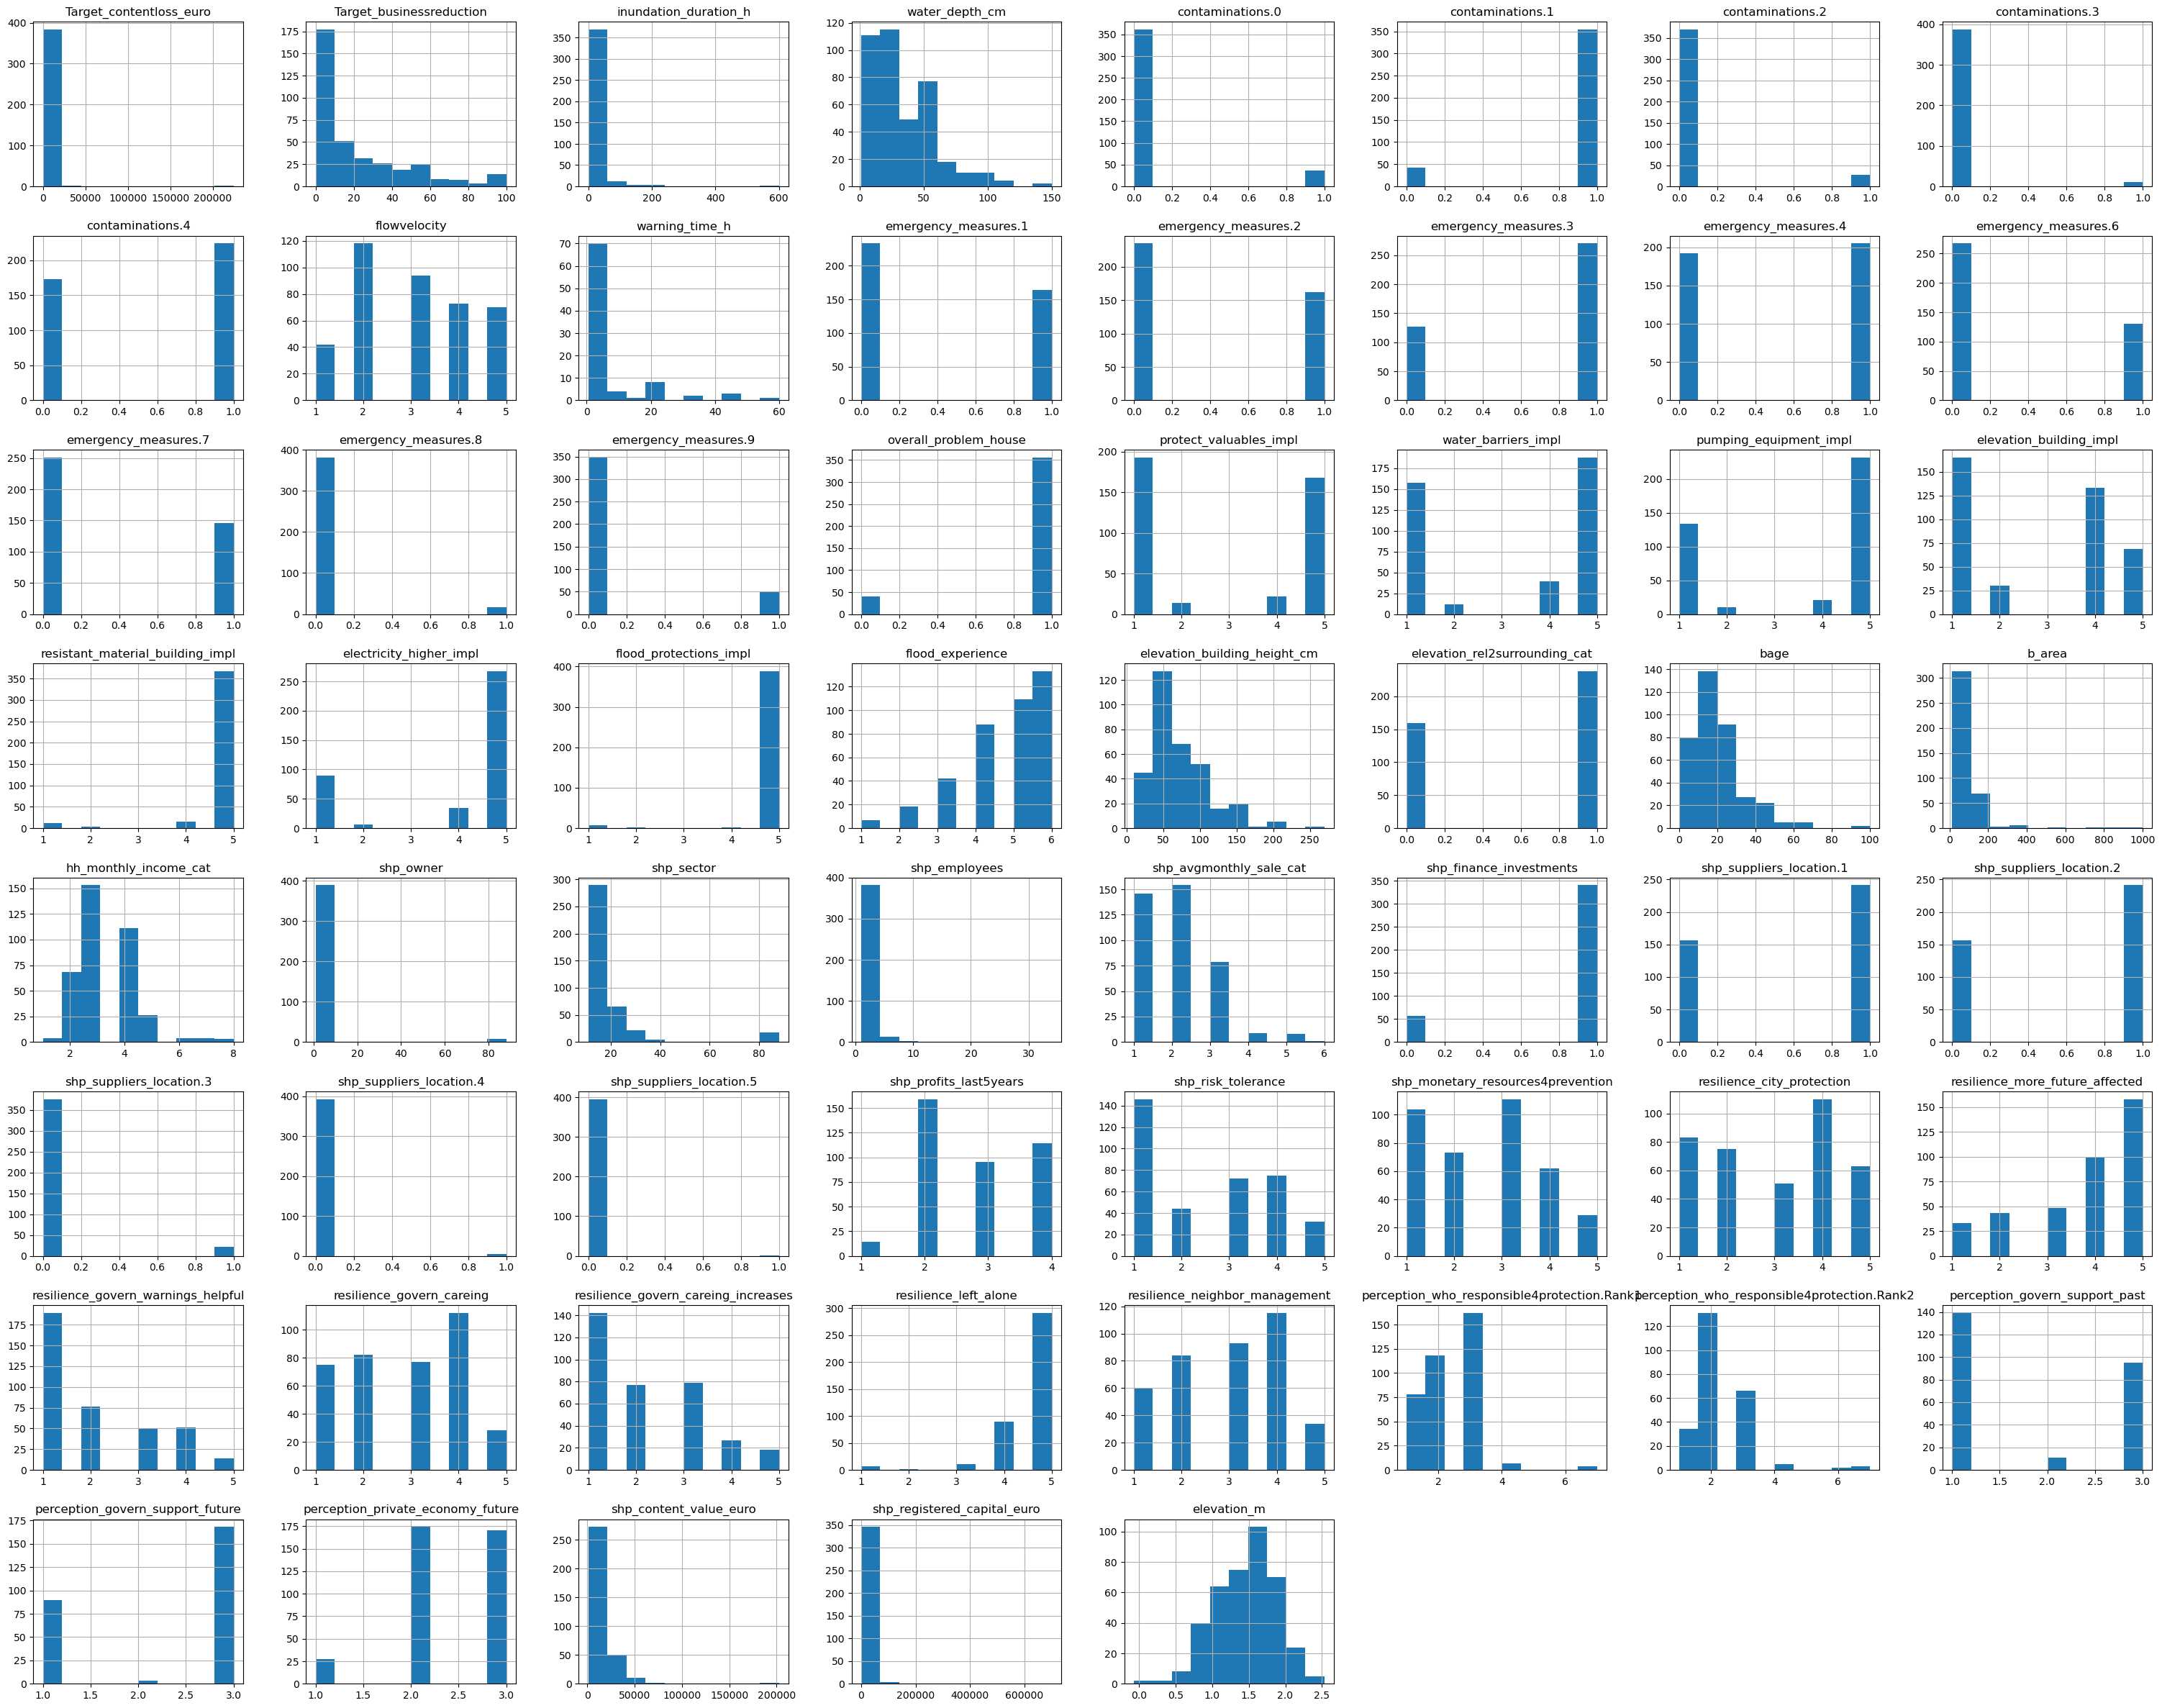

: 

In [8]:
df_candidates.hist(bins=10, figsize=(38, 30));


### select continous variables

In [151]:
df_candidates.columns

Index(['Target_direct', 'business_reduction', 'inundation_duration_h',
       'water_depth_cm', 'warning_time_h', 'shp_damage_level_furniture',
       'shp_damage_level_electronics', 'shp_damage_level_equipment',
       'shp_damage_level_products', 'shp_damage_level_others', 'shp_closed_d',
       'shp_duration_back2normal', 'contaminations', 'emergency_measures',
       'protect_valuables_impl', 'water_barries_impl',
       'pumping_equipment_impl', 'elevation_building_impl',
       'resistant_material_building_impl', 'electricity_higher_impl',
       'flood_protections_impl', 'elevation_building_height_cm',
       'insurance_business', 'building_elevation_rel2surrounding_cat',
       'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_mVND',
       'shp_capital_mVND', 'shp_risk_behaviour',
       'shp_monetary_resources_prenvention', 'building_floor', 'elevation_m'],
      dtype='object')

In [152]:
# Columns that require discretization 

continous_vars_list = [
    r"^Target*", "business_reduction", "water_depth", 
    "inundation_duration_h", "warning_time_h", "shp_closed_d",
    "shp_duration_back2normal", "elevation_building_height_cm", 
    "building_floorsize_sqm", 
    "building_renovation_cost_mVND*", "shp_employees", r"shp_capital_mVND$", "elevation_m"
]

pattern_cols = re.compile('|'.join(continous_vars_list))

# further continous vars not in candidates: 
# flow_velocity, repair_costs_building_VND_r, repair_costs_building_complete_r, building_renovation_cost_mVND_r
# *_spnd where  not 2 or 99 , "cost for elevations" not 1 or 99,

df_continous = df_candidates.filter(regex=pattern_cols) 
#df_continous.head(2)
df_continous.describe()

#df_discrete = df_candidates.iloc[:, ~df_candidates.filter(regex=pattern_cols) ]

,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_closed_d,shp_duration_back2normal,elevation_building_height_cm,shp_employees,shp_capital_mVND,elevation_m
count,504.000000,503.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,500.000000
mean,33.884524,25.803181,14.146230,34.950397,1.582341,4.216270,5.769841,62.194444,2.003968,158.100794,3.620000
std,381.069413,32.887939,48.022307,26.028573,6.943801,23.781202,24.941096,44.112790,2.405259,1221.034503,1.816094
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000
25%,0.000000,0.000000,2.000000,15.000000,0.000000,0.000000,0.000000,38.750000,1.000000,7.000000,3.000000
50%,0.000000,10.000000,3.000000,30.000000,0.000000,0.000000,0.000000,60.000000,2.000000,20.000000,3.000000
75%,3.000000,40.000000,6.000000,50.000000,0.000000,2.000000,3.000000,84.750000,2.000000,50.000000,5.000000
max,6000.000000,100.000000,600.000000,150.000000,60.000000,365.000000,365.000000,270.000000,34.000000,19000.000000,13.000000


In [153]:
## TODO check for 99 and in specific cols also for 2
df_candidates_clean[(df_candidates_clean == 2).any(axis=1)]

## replace 99 by 0.0
df_candidates_clean = df_candidates_clean.replace(99, 0.0)

In [162]:
#' The dataframe that maps the number of classes to each 
#' variables that needs discretization 
discretization_df = pd.DataFrame(columns = df_continous.columns)#, classes = rep(n_classes, len(continous_vars_list))) 
discretization_df

# Discretize model data 
# # Filter out cases with missing data 
#print(df_candidates.isna().sum())
print(df_candidates.shape)
## remove observations with missing information
df_candidates_clean = df_candidates.dropna()
print(df_candidates_clean.shape)

# #' Discretize relative loss manually to receive the desired bin widths:
#  #' i.e. zero and one cases are one category 
# #' and the rest is disretized based on equal frequency 

## TODO set 0.0 to one class, and outlier also to one class with min. two observations, than apply equal frequency 
#cutpoints_dloss = [0.0, 0.01, 0.25, 0.50, 0.75, 1.0]#[0, 1.00e-9, 0.053, 0.168, 0.967, 1]  # eg. [0, .25, .5, .75, 1.] list or number for quartile
#target_direct_disc = pd.qcut(df_candidates_clean.Target_direct, q=10, precision=2,#cutpoints_dloss, labels=False,
#                              duplicates="drop", retbins=False)
discretization_df["Target_direct"] = pd.cut(df_candidates_clean.Target_direct, [-00.1, 0.01, 1.0, 5.0, 10.0, 20.0, 50.0, 100.0, 6000.0],
               labels=[0, 1, 2, 3, 4, 5, 6, 7])
    


print(discretization_df.tail(2))
#print(df_candidates_clean.Target_direct.value_counts())


(504, 32)
(499, 32)


In [220]:
discretization_df["Target_direct"].value_counts()

Target_direct
0    285
2     72
1     55
3     33
4     19
5     18
6      9
7      8
Name: count, dtype: int64

In [167]:
# Discretize remaining continuous variables and combine in one data frame 
print("quantile cutting:")
for c in df_continous.columns.drop("Target_direct"):
   discretization_df[c] = pd.qcut(df_continous[c], q=[.000, .001, .25, .5, .75, 1.], precision=1, labels=False,  duplicates="drop") #cutpoints_dloss, labels=False,

discretization_df.describe()


## Check whether desired discretization was achieved 
# sapply(data_disc, function(x)length(levels(x)))

,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_closed_d,shp_duration_back2normal,elevation_building_height_cm,shp_employees,shp_capital_mVND,elevation_m
count,499.000000,499.000000,499.000000,499.0,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.687375,1.332665,1.330661,0.0,0.234469,0.246493,1.426854,0.164329,1.454910,0.631263
std,0.839811,1.186248,1.057048,0.0,0.424092,0.431401,1.121244,0.370945,1.106512,0.711569
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,2.000000,2.000000,0.0,0.000000,0.000000,3.000000,0.000000,2.000000,1.000000
max,2.000000,3.000000,3.000000,0.0,1.000000,1.000000,3.000000,1.000000,3.000000,2.000000


In [216]:
discretization_df.business_reduction.value_counts()

business_reduction
0.0    278
2.0    122
1.0     99
Name: count, dtype: int64

In [218]:
## combine dsicretized df with other categorical vairables

for c in discretization_df.columns:
    df_candidates[c] = discretization_df[c]  

print(df_candidates.shape)
df_candidates.tail(3)

(504, 32)


,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,shp_damage_level_others,...,insurance_business,building_elevation_rel2surrounding_cat,shp_sector,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,building_floor,elevation_m
501,2,0.0,3.0,1.0,0.0,1,1,3,1,0,...,2,0,15,1.0,4,3.0,2,4,0,0.0
502,2,2.0,0.0,0.0,0.0,2,2,4,2,0,...,2,0,17,0.0,1,1.0,2,1,1,1.0
503,0,2.0,2.0,1.0,0.0,2,1,1,1,0,...,2,0,17,0.0,2,2.0,3,3,0,0.0


In [219]:
df_candidates.to_excel("../input_survey_data/survey_data_candidates_coords_disc.xlsx", index=False)
